In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline 

# Results

In [3]:
path = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/processed_results/'

# Plotting

In [4]:
# color dict (use: colors['XColor'])
import ast
with open('color_palette.txt', 'r') as file:
    contents = file.read()
    colors = ast.literal_eval(contents)

In [10]:
def plot_curves(title, pred, metric): 
    
    df = pd.read_pickle(path + pred +'_randerr_mll_scikit_compare_' + metric + '.pkl')
    
    plt.clf()    
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)   
    #ax.set_title(title, fontsize=20, pad=15)
    
    axlbls = {'MAE' : 'Negative MAE', 
              'MedAE' : 'Negative MedAE', 
              'MAPE' : 'Negative MAPE [%]',
              'Acc' : 'Accuracy Score',
              'BalAcc' : 'Balanced Accuracy Score'}
    dflbls = {'MAE' : 'Neg MAE', 
              'MedAE' : 'Neg MedAE', 
              'MAPE' : 'Neg MAPE', 
              'Acc' : 'Accuracy',
              'BalAcc' : 'Balanced Accuracy'}
    fb = {'MAE' : 'MAE Std', 
          'MAPE' : 'MAPE Std', 
          'Acc' : 'Acc CI',
          'BalAcc' : 'BalAcc CI'}
    sv_base = 'plots/randerr_compare_nuc29_'
    if 'Burnup' in title:
        axlbl = axlbls[metric] + ' [MWd/MTU]'
        sv_fig = sv_base + metric + '_burn.png'
    elif 'Reactor' in title:
        axlbl = axlbls[metric]
        sv_fig = sv_base + metric + '_rxtr.png'
    elif 'Enrichment' in title:
        axlbl = axlbls[metric] + ' [% U235]'
        sv_fig = sv_base + metric + '_enri.png'
    else:
        axlbl = axlbls[metric] + ' [days]'
        sv_fig = sv_base + metric + '_cool.png'
    ax.set_xlabel('Percent Error', fontsize=20, labelpad=15)
    ax.set_ylabel(axlbl, fontsize=20, labelpad=15) 
    
    lbls = ['kNN', 'Dec Tree', 'MLL Calc']
    med = ['MBrwn', 'MTeal', 'MPurp']
    dark = ['DBrwn', 'DTeal', 'DPurp']
    d_x = [-0.17, 0, 0.17]
    mll_errs = [1, 5, 10, 15, 20]
    sk_errs = [0, 1, 2, 5, 8, 10, 12, 15, 18, 20]
    for i, alg in enumerate(['knn', 'dtree', 'mll']):
        if alg == 'mll':
            err = mll_errs
        else:
            err = sk_errs
        y = df.loc[err, (alg, dflbls[metric])]
        print(alg, y)
        if metric == 'MedAE':
            yerr = [df.loc[err, (alg, 'IQR_25')], df.loc[err, (alg, 'IQR_75')]]
        else:
            yerr = df.loc[err, (alg, fb[metric])]
        trans = Affine2D().translate(d_x[i], 0.0) + ax.transData
        _, _, bars = ax.errorbar(err, y, yerr=yerr, transform = trans, color=colors[med[i]], marker='o', mew=0, ms=7, elinewidth=3, label=lbls[i])
        [bar.set_alpha(0.4) for bar in bars]
    
    ax.tick_params(labelsize=14)
    #AxesDecorator(ax, ticks=mll_errs)
    ax.legend(loc='lower left')
    
    return fig, ax, sv_fig, df

In [9]:
def inset_re(fig, ax, pred, metric, df):
    dflbls = {'MAE' : 'Neg MAE', 
              'MedAE' : 'Neg MedAE', 
              'MAPE' : 'Neg MAPE', 
              'Acc' : 'Accuracy',
              'BalAcc' : 'Balanced Accuracy'}
    fb = {'MAE' : 'MAE Std', 
          'MAPE' : 'MAPE Std', 
          'Acc' : 'Acc CI',
          'BalAcc' : 'BalAcc CI'}
    lbls = ['kNN', 'Dec Tree', 'MLL Calc']
    med = ['MBrwn', 'MTeal', 'MPurp']
    dark = ['DBrwn', 'DTeal', 'DPurp']
    d_x = [-0.17, 0, 0.17]
    mll_errs = [1, 5, 10, 15, 20]
    sk_errs = [0, 1, 2, 5, 8, 10, 12, 15, 18, 20]
    for i, alg in enumerate(['knn', 'dtree', 'mll']):
        if alg == 'mll':
            err = mll_errs
        else:
            err = sk_errs
        y = df.loc[err, (alg, dflbls[metric])]
        if metric == 'MedAE':
            yerr = [df.loc[err, (alg, 'IQR_25')], df.loc[err, (alg, 'IQR_75')]]
        else:
            yerr = df.loc[err, (alg, fb[metric])]
        trans = Affine2D().translate(d_x[i], 0.0) + ax.transData
        _, _, bars = ax.errorbar(err, y, yerr=yerr, transform = trans, color=colors[med[i]], marker='o', mew=0, ms=7, elinewidth=3, label=lbls[i])
        [bar.set_alpha(0.4) for bar in bars]
    
    return fig, ax

In [7]:
class AxesDecorator():
    def __init__(self, ax, size="2%", pad=0.05, ticks=[1,2,3], spacing=0.05,
                 color="k"):
        self.divider= make_axes_locatable(ax)
        self.ax = self.divider.new_vertical(size=size, pad=pad, sharex=ax, pack_start=True)
        ax.figure.add_axes(self.ax)
        self.ticks=np.array(ticks)
        self.d = np.mean(np.diff(ticks))
        self.spacing = spacing
        self.get_curve()
        self.color=color
        for x0 in ticks:
            self.plot_curve(x0)
        self.ax.set_yticks([])
        plt.setp(ax.get_xticklabels(), visible=False)
        self.ax.tick_params(axis='x', which=u'both',length=0)
        ax.tick_params(axis='x', which=u'both',length=0)
        for direction in ["left", "right", "bottom", "top"]:
            self.ax.spines[direction].set_visible(False)
        self.ax.set_xlabel(ax.get_xlabel())
        ax.set_xlabel("")
        self.ax.set_xticks(self.ticks)

    def plot_curve(self, x0):
        x = np.linspace(x0-self.d/2.*(1-self.spacing),x0+self.d/2.*(1-self.spacing), 50 )
        self.ax.plot(x, self.curve, c=self.color)

    def get_curve(self):
        lx = np.linspace(-np.pi/2.+0.05, np.pi/2.-0.05, 25)
        tan = np.tan(lx)*10
        self.curve = np.hstack((tan[::-1],tan))
        return self.curve

## Reactor Type

<Figure size 432x288 with 0 Axes>

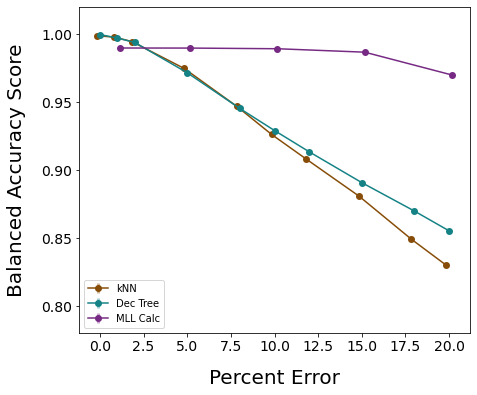

In [14]:
fig, ax, sv_fig = plot_curves('Reactor Type Prediction', 'reactor', 'BalAcc')
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_ylim(0.78, 1.02)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

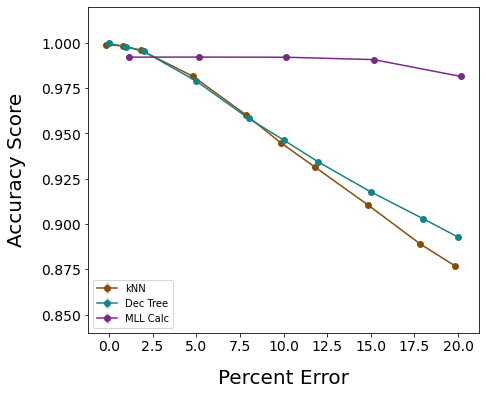

In [15]:
fig, ax, sv_fig = plot_curves('Reactor Type Prediction', 'reactor', 'Acc')
ax.set_ylim(0.84, 1.02)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

## Burnup

<Figure size 432x288 with 0 Axes>

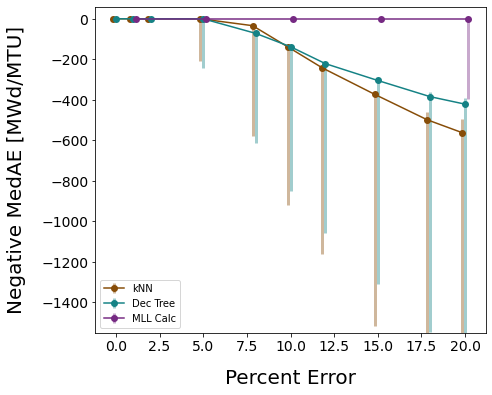

In [23]:
fig, ax, sv_fig = plot_curves('Burnup Prediction', 'burnup', 'MedAE')
ax.set_ylim(-1550, 60)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

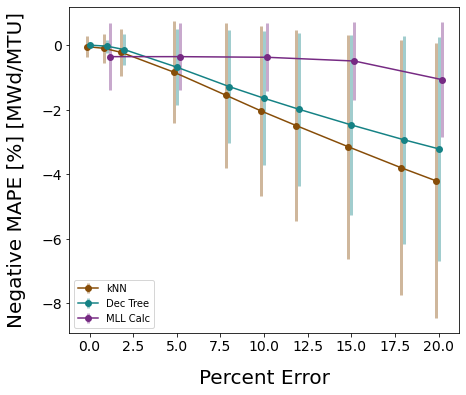

In [24]:
fig, ax, sv_fig = plot_curves('Burnup Prediction', 'burnup', 'MAPE')
#ax.set_ylim(None, 250)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

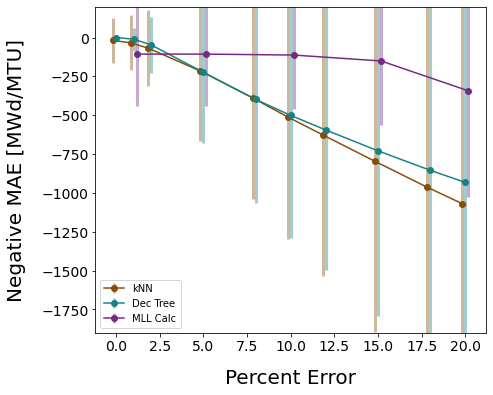

In [25]:
fig, ax, sv_fig = plot_curves('Burnup Prediction', 'burnup', 'MAE')
ax.set_ylim(-1900, 199)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

## Enrichment

<Figure size 432x288 with 0 Axes>

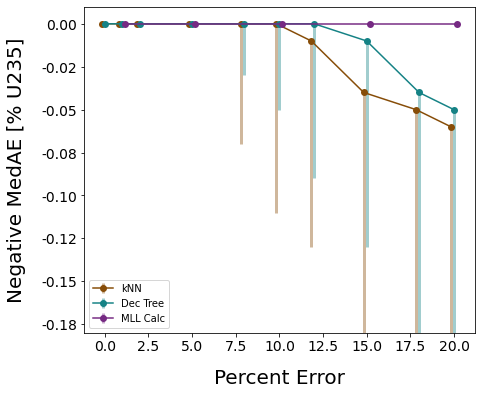

In [26]:
fig, ax, sv_fig = plot_curves('U235 Enrichment Prediction', 'enrichment', 'MedAE')
ax.set_ylim(-0.18, 0.01)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

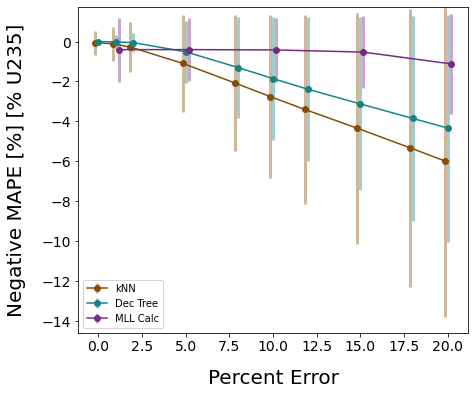

In [27]:
fig, ax, sv_fig = plot_curves('U235 Enrichment Prediction', 'enrichment', 'MAPE')
ax.set_ylim(None, 1.75)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

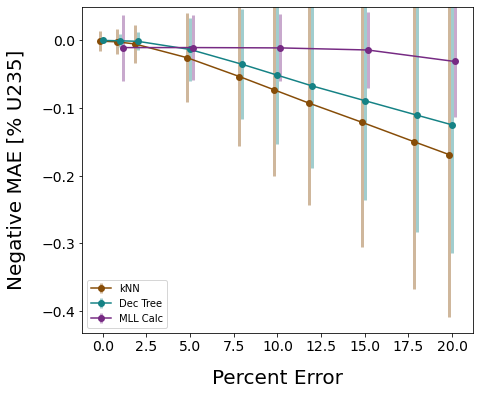

In [28]:
fig, ax, sv_fig = plot_curves('U235 Enrichment Prediction', 'enrichment', 'MAE')
ax.set_ylim(None, 0.05)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

## Time Since Irraditation

<Figure size 432x288 with 0 Axes>

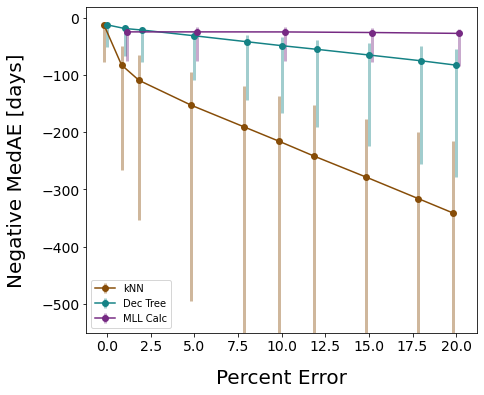

In [29]:
fig, ax, sv_fig = plot_curves('Time Since Irradiation Prediction', 'cooling', 'MedAE')
ax.set_ylim(-550, 19)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

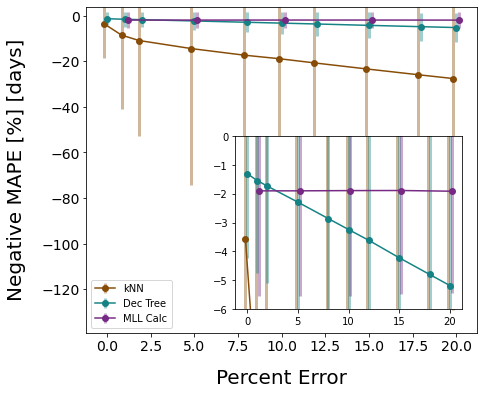

In [96]:
fig, ax, sv_fig, df = plot_curves('Time Since Irradiation Prediction', 'cooling', 'MAPE')
ax.set_ylim(None, 4)

# inset
inset_ax = fig.add_axes([0.42, 0.18, 0.45, 0.4]) # X, Y, width, height
fig, inset_ax = inset_re(fig, inset_ax, 'cooling', 'MAPE', df) 
inset_ax.set_ylim(-6, 0)
plt.show()

fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

knn 0     -51.273171
1    -164.876356
2    -216.878619
5    -292.400121
8    -349.483257
10   -383.358068
12   -418.924882
15   -468.509998
18   -514.333476
20   -544.813369
Name: (knn, Neg MAE), dtype: float64
dtree 0     -28.160911
1     -34.993555
2     -40.023002
5     -54.467696
8     -69.311689
10    -79.744976
12    -89.816323
15   -105.593907
18   -121.430372
20   -131.832424
Name: (dtree, Neg MAE), dtype: float64
mll 1    -38.671463
5    -38.621384
10   -38.450410
15   -39.027282
20   -41.303070
Name: (mll, Neg MAE), dtype: float64


ValueError: too many values to unpack (expected 3)

<Figure size 432x288 with 0 Axes>

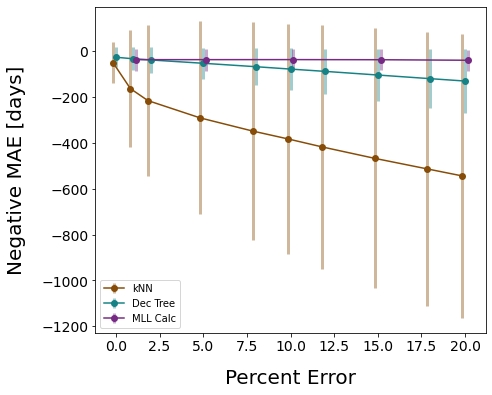

In [11]:
fig, ax, sv_fig = plot_curves('Time Since Irradiation Prediction', 'cooling', 'MAE')
ax.set_ylim(-860, 39)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

# Learning Curve Test

In [7]:
df = pd.read_pickle(path + 'learncurve_err05_mll_scikit_compare.pkl')

In [8]:
def inset_lc(fig, ax, pred, metric):
    dflbls = {'MAE' : 'MAE', 
              'MedAE' : 'MedAE', 
              'MAPE' : 'MAPE', 
              'Acc' : 'Accuracy',
              'BalAcc' : 'Balanced Accuracy'}
    fb = {'MAE' : 'MAE Std', 
          'MAPE' : 'MAPE Std', 
          'Acc' : 'Acc CI',
          'BalAcc' : 'BalAcc CI'}
    med = ['MBrwn', 'MTeal', 'MPurp']
    dark = ['DBrwn', 'DTeal', 'DPurp']
    sizes = [20, 40, 60, 80, 100]
    d_x = [-1, 0, 1]
    for i, alg in enumerate(['knn', 'dtree', 'mll']):
        y = df.loc[(sizes, pred), (alg, dflbls[metric])]
        if metric == 'MedAE':
            yerr = [-df.loc[(sizes, pred), (alg, 'IQR_25')], -df.loc[(sizes, pred), (alg, 'IQR_75')]]
        else:
            yerr = -df.loc[(sizes, pred), (alg, fb[metric])]
        trans = Affine2D().translate(d_x[i], 0.0) + ax.transData
        if pred == 'reactor':
            _, _, bars = ax.errorbar(sizes, y, yerr=-yerr, transform=trans, color=colors[med[i]], marker='o', mew=0, ms=7, elinewidth=3)
        else:
            _, _, bars = ax.errorbar(sizes, -y, yerr=yerr, transform=trans, color=colors[med[i]], marker='o', mew=0, ms=7, elinewidth=3)
        [bar.set_alpha(0.4) for bar in bars]
        
    return fig, ax

In [9]:
def plot_learncurves(title, pred, metric): 
    plt.clf()    
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)   
    #ax.set_title(title, fontsize=20, pad=15)
    
    axlbls = {'MAE' : 'Negative MAE', 
              'MedAE' : 'Negative MedAE', 
              'MAPE' : 'Negative MAPE [%]',
              'Acc' : 'Accuracy Score',
              'BalAcc' : 'Balanced Accuracy Score'}
    dflbls = {'MAE' : 'MAE', 
              'MedAE' : 'MedAE', 
              'MAPE' : 'MAPE', 
              'Acc' : 'Accuracy',
              'BalAcc' : 'Balanced Accuracy'}
    fb = {'MAE' : 'MAE Std', 
          'MAPE' : 'MAPE Std', 
          'Acc' : 'Acc CI',
          'BalAcc' : 'BalAcc CI'}
    #sv_base = 'plots/learncurve_nuc29_err01_'
    sv_base = 'plots/learncurve_nuc29_err05_'
    if 'Burnup' in title:
        axlbl = axlbls[metric] + ' [MWd/MTU]'
        sv_fig = sv_base + metric + '_burn.png'
    elif 'Reactor' in title:
        axlbl = axlbls[metric]
        sv_fig = sv_base + metric + '_rxtr.png'
    elif 'Enrichment' in title:
        axlbl = axlbls[metric] + ' [% U235]'
        sv_fig = sv_base + metric + '_enri.png'
    else:
        axlbl = axlbls[metric] + ' [days]'
        sv_fig = sv_base + metric + '_cool.png'
    ax.set_xlabel('% of Training Set', fontsize=20, labelpad=15)
    ax.set_ylabel(axlbl, fontsize=20, labelpad=15) 
    
    lbls = ['kNN', 'Dec Tree', 'MLL Calc']
    med = ['MBrwn', 'MTeal', 'MPurp']
    dark = ['DBrwn', 'DTeal', 'DPurp']
    sizes = [20, 40, 60, 80, 100]
    d_x = [-1, 0, 1]
    for i, alg in enumerate(['knn', 'dtree', 'mll']):
        y = df.loc[(sizes, pred), (alg, dflbls[metric])]
        if metric == 'MedAE':
            yerr = [-df.loc[(sizes, pred), (alg, 'IQR_25')], -df.loc[(sizes, pred), (alg, 'IQR_75')]]
        else:
            yerr = -df.loc[(sizes, pred), (alg, fb[metric])]
        trans = Affine2D().translate(d_x[i], 0.0) + ax.transData
        if pred == 'reactor':
            _, _, bars = ax.errorbar(sizes, y, yerr=-yerr, transform=trans, color=colors[med[i]], marker='o', mew=0, ms=7, elinewidth=3, label=lbls[i])
        else:
            _, _, bars = ax.errorbar(sizes, -y, yerr=yerr, transform=trans, color=colors[med[i]], marker='o', mew=0, ms=7, elinewidth=3, label=lbls[i])
        [bar.set_alpha(0.4) for bar in bars]
        
    ax.tick_params(labelsize=14)
    ax.legend(loc='lower right')
    
    return fig, ax, sv_fig

<Figure size 432x288 with 0 Axes>

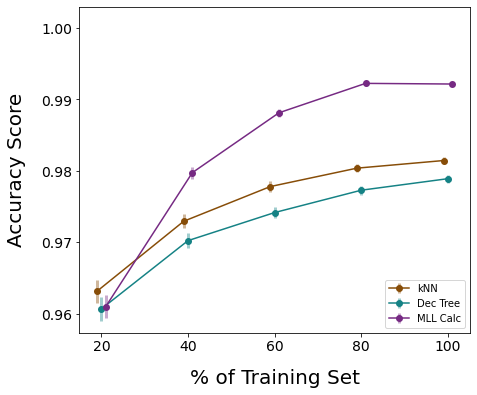

In [22]:
fig, ax, sv_fig = plot_learncurves('Learning Curve: Reactor Type Prediction', 'reactor', 'Acc')
ax.set_ylim(None, 1.003)
plt.show()
#fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

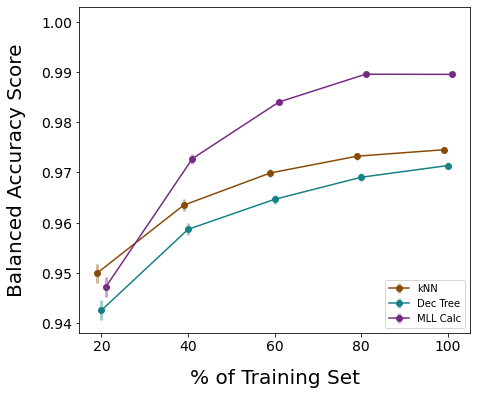

In [21]:
fig, ax, sv_fig = plot_learncurves('Learning Curve: Reactor Type Prediction', 'reactor', 'BalAcc')
ax.set_ylim(None, 1.003)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

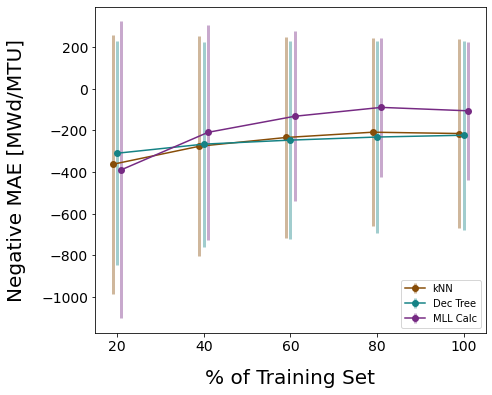

In [33]:
fig, ax, sv_fig = plot_learncurves('Learning Curve: Burnup Prediction', 'burnup', 'MAE')
#ax.set_ylim(None, 100)
plt.show()
#fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

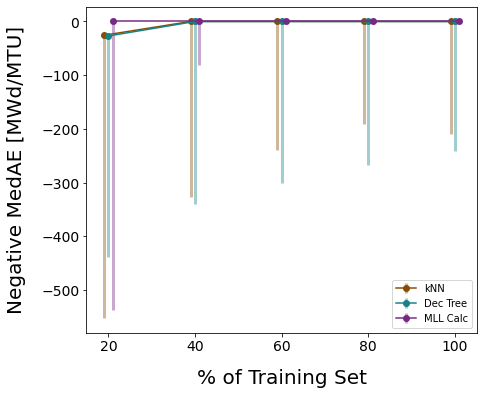

In [34]:
fig, ax, sv_fig = plot_learncurves('Learning Curve: Burnup Prediction', 'burnup', 'MedAE')
#ax.set_ylim(-560, 39)
plt.show()
#fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

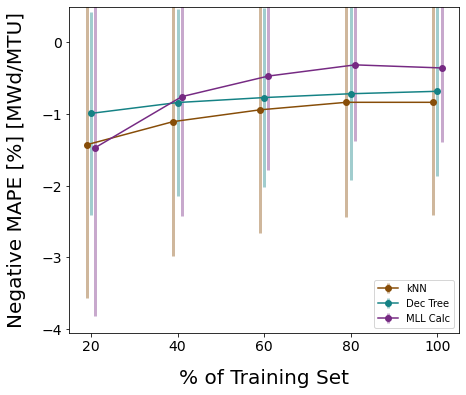

In [71]:
fig, ax, sv_fig = plot_learncurves('Learning Curve: Burnup Prediction', 'burnup', 'MAPE')
ax.set_ylim(None, 0.5)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

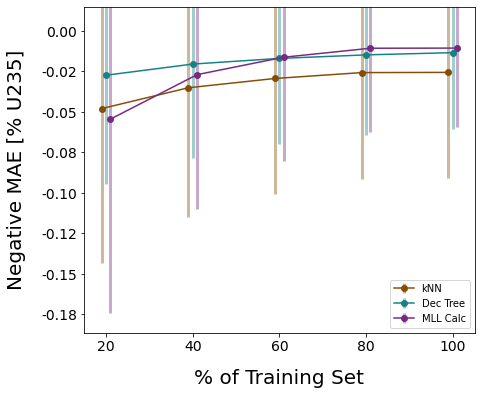

In [38]:
fig, ax, sv_fig = plot_learncurves('Learning Curve: U235 Enrichment Prediction', 'enrichment', 'MAE')
ax.set_ylim(None, 0.015)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()
#fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

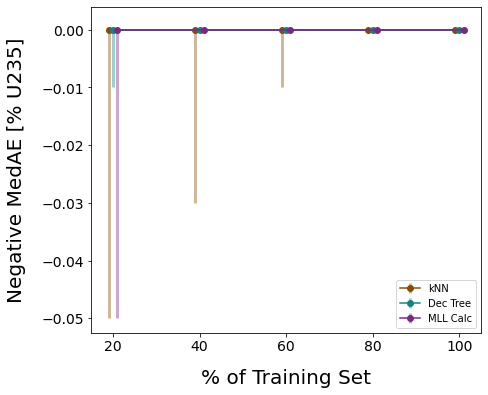

In [45]:
fig, ax, sv_fig = plot_learncurves('Learning Curve: U235 Enrichment Prediction', 'enrichment', 'MedAE')
ax.set_ylim(None, 0.004)
plt.show()
#fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

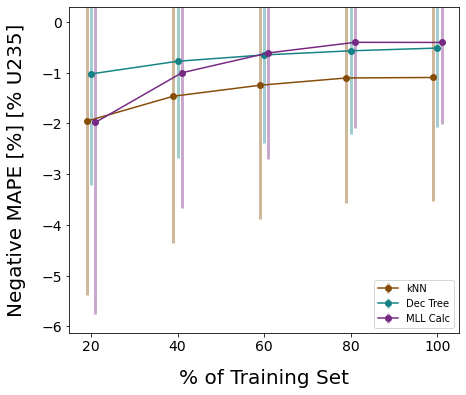

In [68]:
fig, ax, sv_fig = plot_learncurves('Learning Curve: U235 Enrichment Prediction', 'enrichment', 'MAPE')
ax.set_ylim(None, 0.3)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

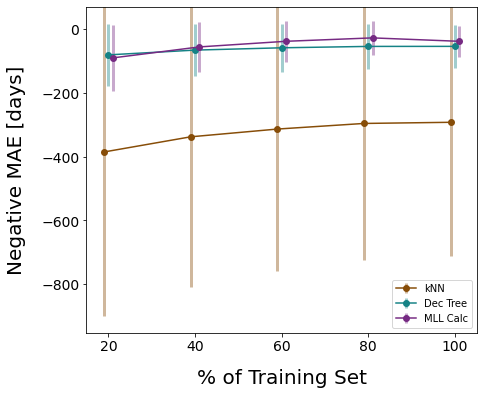

In [48]:
fig, ax, sv_fig = plot_learncurves('Learning Curve: Time Since Irradiation Prediction', 'cooling', 'MAE')
ax.set_ylim(None, 70)
plt.show()
#fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

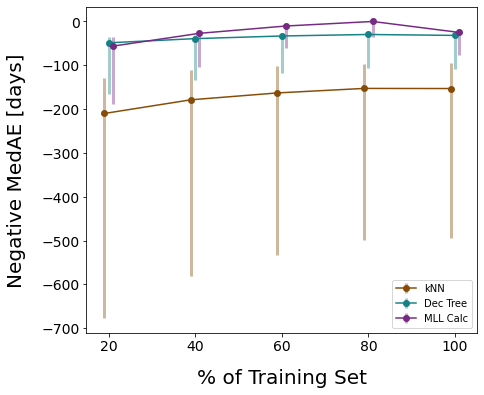

In [49]:
fig, ax, sv_fig = plot_learncurves('Learning Curve: Time Since Irradiation Prediction', 'cooling', 'MedAE')
#ax.set_ylim(-560, 39)
plt.show()
#fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

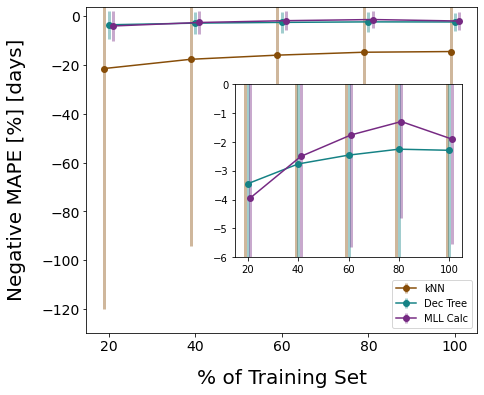

In [12]:
fig, ax, sv_fig = plot_learncurves('Learning Curve: Time Since Irradiation Prediction', 'cooling', 'MAPE')
ax.set_ylim(None, 4)

# inset
inset_ax = fig.add_axes([0.42, 0.3, 0.45, 0.4]) # X, Y, width, height
fig, inset_ax = inset_lc(fig, inset_ax, 'cooling', 'MAPE') 
inset_ax.set_ylim(-6, 0)
plt.show()

fig.savefig(sv_fig, bbox_inches='tight', transparent=True)